
# Install pytorch on conda

1. know the version of cuda you have installed

```
nvcc -V 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2016 NVIDIA Corporation
Built on Sun_Sep__4_22:14:01_CDT_2016
Cuda compilation tools, release 8.0, V8.0.44
```

So seems we have the cuda 8.0 version


# Install pytorch

```
coda install pytorch cuda80 torchvision -c soumith
```

Inspiration from:

https://github.com/desimone/pytorch-cat-vs-dogs/blob/master/main.py

and 

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
## download data and put train.zip and test.zip at the root of this ipynb

## train first

!unzip train.zip 1>/dev/null 2>/dev/null;
!mkdir -p train
!mkdir train/cat
!mkdir train/dog
!mv train/cat*.jpg train/cat/
!mv train/dog*.jpg train/dog/

## test
!unzip test.zip 1>/dev/null 2>/dev/null;

!ls -la train/dog | wc -l
!ls -la train/cat | wc -l
!ls -la test/ | wc -l

mkdir: cannot create directory ‘train/cat’: File exists
mkdir: cannot create directory ‘train/dog’: File exists
^C
12503
12503
12503


In [1]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


BATCH_SIZE = 200

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


traindir = "./train"
    
trainData = datasets.ImageFolder(traindir, transforms.Compose([
     transforms.RandomSizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     normalize,
]))


valData = datasets.ImageFolder(traindir, transforms.Compose([
     transforms.Scale(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     normalize,
]))

In [2]:
import numpy as np


dataSize = len(trainData.imgs) ## number of images
VALIDATION_SIZE = int(dataSize * 0.2)

validation_index = np.random.choice(dataSize, VALIDATION_SIZE, False)
train_index = [index for index in range(dataSize) if index not in validation_index]

In [3]:
import torch.utils.data as data


train_sampler = data.sampler.SubsetRandomSampler(train_index)
val_sampler = data.sampler.SubsetRandomSampler(validation_index)

train_loader = data.DataLoader(trainData, BATCH_SIZE, shuffle=True, sampler=train_sampler)
val_loader = data.DataLoader(valData, BATCH_SIZE, shuffle=True, sampler=val_sampler)

In [4]:
## Create models

## Use a resnet101 for transform images into 2048 features
## create a custom linear nn to decide how this features decide if there is a cat or a dog

## Load a pretrained model
import torchvision.models as models
import torch.nn as nn

resnet = models.resnet101(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.cuda()

resnet_features = []
## HACK to remove the fc from the computation
def forward( x):
        x = resnet.conv1(x)
        x = resnet.bn1(x)
        x = resnet.relu(x)
        x = resnet.maxpool(x)

        x = resnet.layer1(x)
        x = resnet.layer2(x)
        x = resnet.layer3(x)
        x = resnet.layer4(x)

        x = resnet.avgpool(x)
        x = x.view(x.size(0), -1)
#        x = self.fc(x)

        return x

## reassign fordward to the network
resnet.forward = forward


## Receive the features of resnet
class CatDogNet(nn.Module):

    def __init__(self, num_features):
        super(CatDogNet, self).__init__()
        self.fc1   = nn.Linear(num_features, 2)

    def forward(self, x):
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

num_features_fc = resnet.fc.in_features
classifier = CatDogNet(num_features_fc).cuda()

print("Models created!")

Models created!


In [5]:
from torch import autograd
import numpy as np

## cache all the image from training and validation to resnet features
## so we do it just once, instead of traversing the network on each epoch to do it 
## once, also store this features into a file so we is faster to execute the full notebook
def resnet_extract_features(loader):
    resnet_features = []
    resnet_target = []

    for i, (images, target) in enumerate(loader):
        images = images.cuda()
        target = target.cuda()

        image_var = autograd.Variable(images, volatile=True)
        target_var = autograd.Variable(target, volatile=True)
    

        y_pred = resnet(image_var)
        resnet_features.append(y_pred.data.cpu().numpy())

        resnet_target.append(target_var.data.cpu().numpy())
        
        if i % 10 == 0:
            print("getted batch %i of %i" % (i, len(loader)))

    target = np.hstack(np.array(resnet_target).flatten())
    features = np.vstack(resnet_features)
    
    return (features, target)



import os.path
import pickle
filename = "data.pickle"

existFile = os.path.isfile(filename)
if existFile:
    ## Load data from file
    with open(filename, 'rb') as f:
        (train_feature, train_target, validation_feature, validation_target) = pickle.load(f)
else:
    ## calculate the features 
    print("training features resnet")
    train_feature, train_target = resnet_extract_features(train_loader)

    print("validation features resnet")
    validation_feature, validation_target = resnet_extract_features(val_loader)
    
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump((train_feature, train_target, validation_feature, validation_target), f)


print("data loaded, " , train_feature.shape, train_target.shape) 



data loaded,  (20000, 2048) (20000,)


In [6]:
## load the model if there was one already created (only for the classifier)

import torch
from torch import autograd
import os

modelFilename = "./model_improved.pth.tar"
if os.path.isfile(modelFilename):
    state = torch.load(modelFilename)
    classifier.load_state_dict(state)
    print("model weight loaded!")


In [7]:
import torch.optim as optim

errorFunction = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(classifier.parameters())


In [8]:
def accuracy(y_pred, y_actual, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = y_actual.size(0)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y_actual.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res

In [9]:
import torch 

def train(print_data = True):
    images = torch.from_numpy(train_feature).cuda()
    target = torch.from_numpy(train_target).cuda()

    image_var = autograd.Variable(images)
    target_var = autograd.Variable(target)
    
    y_pred = classifier(image_var)
    loss = errorFunction(y_pred, target_var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = accuracy(y_pred.data, target)
    
    if print_data:
        print("training accuracy %f loss: %f" % (acc[0][0], loss.data[0]))
    

In [10]:
def validate(print_data = True):
    images = torch.from_numpy(validation_feature).cuda()
    target = torch.from_numpy(validation_target).cuda()

    image_var = autograd.Variable(images)
    target_var = autograd.Variable(target)
    
    y_pred = classifier(image_var)
    loss = errorFunction(y_pred, target_var)

    acc = accuracy(y_pred.data, target)
    if print_data:
        print("validation accuracy %f loss: %f" % (acc[0][0], loss.data[0]))

    return loss.data[0]


In [11]:
import time

def do_train(total_epochs = 1000, print_each = 100):
    for epoch in range(total_epochs):
        should_print = epoch % print_each  == 0
        if should_print:
            print("start epoch %i" % epoch)

        train(should_print)
        loss = validate(should_print)

        if should_print:
            torch.save(classifier.state_dict(), './model_%i.pth.tar' % epoch)
    

In [12]:
## Visualize data :)
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def imshow(inp, ax):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    ax.imshow(inp)

def visualize(num_rows=3, num_cols=5):
    images, _ = next(iter(test_loader))
    images = autograd.Variable(images.cuda(), volatile=True)
    
    resnet_feature = resnet(images)
    y_pred = classifier(resnet_feature)
    _, preds = torch.max(y_pred.data, 1)

    i = 0
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_rows, 4 * num_cols))
    axes = [item for sublist in axes for item in sublist] ## flatten axes

    for i in range(num_rows * num_cols):
        axe = axes[i]
        
        class_idx = preds.cpu().numpy()[i][0]
        class_name = valData.classes[class_idx]
        
        axe.set_title(class_name)
        imshow(images.cpu().data[i], axe)

    plt.show()



In [13]:
##\0Test !!!
from PIL import Image
import csv
import os

class TestImageFolder(data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)


testData = TestImageFolder('./test',
                           transforms.Compose([
                               transforms.Scale(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize,
                           ]))
TEST_BATCH_SIZE = 50
test_loader = data.DataLoader(testData, TEST_BATCH_SIZE)


def test():

    csv_map = {}

    resnet.eval()  ##\xa0disable droupout

    for i, (images, filepath) in enumerate(test_loader):
        print("batch %i size %i of %i" %
              (i, TEST_BATCH_SIZE, len(test_loader.dataset.imgs)))

        filepath = list(
            map(lambda f: int(os.path.splitext(os.path.basename(f))[0]),
                filepath))
        image_var = torch.autograd.Variable(images, volatile=True).cuda()

        resnet_feature = resnet(image_var)
        y_pred = classifier(resnet_feature)
        # get the index of the max log-probability
        smax = nn.Softmax()

        for i in range(len(y_pred)):
            smax_out = smax(y_pred)[i]
            cat_prob = smax_out.data[0]
            dog_prob = smax_out.data[1]
            prob = dog_prob
            if cat_prob > dog_prob:
                prob = 1 - cat_prob
            prob = np.around(prob, decimals=4)
            prob = np.clip(prob, .0001, .999)
            csv_map[filepath[i]] = prob
        # print("{},{}".format(filepath, prob))

    with open('entry.csv', 'w') as csvfile:
        fieldnames = ['id', 'label']
        csv_w = csv.writer(csvfile)
        csv_w.writerow(('id', 'label'))
        for row in sorted(csv_map.items()):
            csv_w.writerow(row)

    return

start epoch 0
training accuracy 96.784996 loss: 0.083022
validation accuracy 98.500000 loss: 0.039650
start epoch 100
training accuracy 96.894997 loss: 0.079040
validation accuracy 98.479996 loss: 0.038373
start epoch 200
training accuracy 97.025002 loss: 0.075871
validation accuracy 98.579994 loss: 0.037553
validation accuracy 98.559998 loss: 0.036973


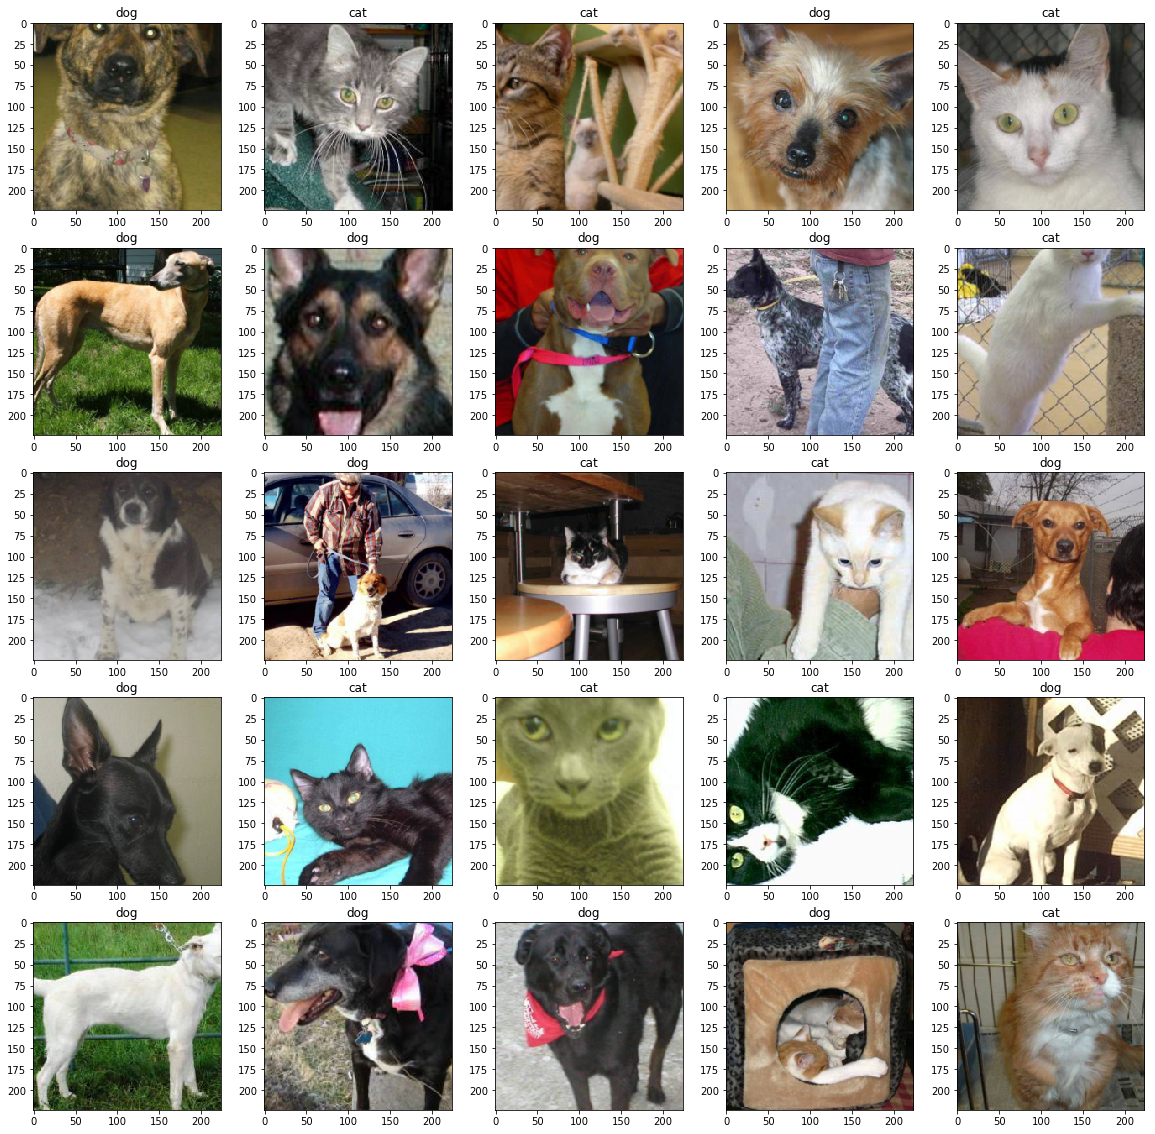

In [17]:
do_train(total_epochs=300)

validate()

visualize(5, 5)

# test()
